In [1]:
import netCDF4 as nc4
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.mplot3d import axes3d
import copy
import pandas as pd
import time
# import xarray as xr
import mpl_toolkits as mpl
# import plotly.graph_objects as go
# import plotly.express as px
from scipy import interpolate


### Collect PPE results

In [2]:
# Open the file and obtain the last value
# This step will take much longer than expected.
start = time.time()

gpp_collect = []
vegc_collect = []
vegc_bl_collect = []
vegc_nl_collect = []
soilc_collect = []
block_ens = [255, 145, 400, 400, 400]
# Path to all ensemble members
block_path = ['ppe_pool/fates_test1/', \
              'ppe_pool/fates_test256/', \
              'ppe_pool/fates_test401/', \
              'ppe_pool/fates_test801/', \
              'ppe_pool/fates_test1201/']
block_prefix = ['fates_test_2024-02-12_e9515ed7a8_5d40c9e6.elm_',\
               'fates_test256_2024-02-12_e9515ed7a8_5d40c9e6.elm_', \
               'fates_test401_2024-02-12_e9515ed7a8_5d40c9e6.elm_', \
               'fates_test801_2024-02-12_e9515ed7a8_5d40c9e6.elm_', \
               'fates_test1201_2024-02-13_e9515ed7a8_5d40c9e6.elm_']

# Loop through blocks
for k in np.arange(0,5):
    for i in np.arange(0,block_ens[k]):
        ens_num = str(i+1).zfill(4)
        fpath = block_path[k] + block_prefix[k]+ens_num+'.h0.1965-02-01-00000.nc'
        # Some issue causes the last 400 ensemble member not finishing the job
        if(k == 4):
            fpath = block_path[k] + block_prefix[k]+ens_num+'.h0.1965-02-01-00000.nc'
        dtc = nc4.Dataset(fpath)
        dgpp = dtc['FATES_GPP'][:]
        dvegc = dtc['FATES_VEGC'][:]
        dvegc_pf = dtc['FATES_VEGC_PF'][:]
        dsoilc = dtc['TOTSOMC_1m'][:]
        dtc.close()
    
        # Obtain the mean results
        gpp_collect.append(np.nanmean(dgpp[:,0])*3600*24*365)
        vegc_collect.append(np.nanmean(dvegc[:,0]))
        vegc_bl_collect.append(np.nanmean(dvegc_pf[:,0,0]))
        vegc_nl_collect.append(np.nanmean(dvegc_pf[:,1,0]))
        soilc_collect.append(np.nanmean(dsoilc[:,0])*1e-3)

end = time.time()
print('Time elapsed: ', end - start)
    

('Time elapsed: ', 75.6159999370575)


In [56]:
vegc_obs = 9.4
soilc_obs = 22.26
gpp_obs = 2.0

# Static 3D scatter plot

fig = plt.figure(figsize=(5,5), dpi=150)
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(vegc_collect, soilc_collect, gpp_collect, s=1)
ax.scatter([vegc_obs], [soilc_obs], [gpp_obs], s=100)

# ax.set_xlim(0, 20)
ax.set_xlabel('Vegetation carbon, kgC m-2')
ax.set_ylabel('Soil carbon, kgC m-2')
ax.set_zlabel('Gross Primary Productivity, kgC m-2 yr-1')
fig.tight_layout()
plt.show()


AttributeError: 'NoneType' object has no attribute 'scatter'

<Figure size 750x750 with 0 Axes>

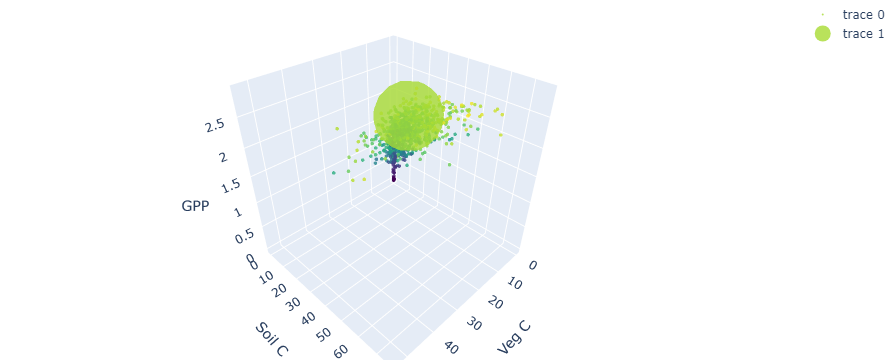

In [5]:
# Rotable 3-D plot
fig = go.Figure(data=[go.Scatter3d(
    x=vegc_collect,
    y=soilc_collect,
    z=gpp_collect,
    mode='markers',
    marker=dict(
        size=2,
        color=gpp_collect,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8),
)])
fig.add_trace(
    go.Scatter3d(x=[vegc_obs],
                 y=[soilc_obs],
                 z=[gpp_obs],
                 mode='markers',
                    marker=dict(
                      size=40,
                      color=gpp_collect,                # set color to an array/list of desired values
                      colorscale='Viridis',   # choose a colorscale
                      opacity=0.8
    ))
)
fig.update_layout(scene = dict(
                    xaxis_title='Veg C',
                    yaxis_title='Soil C',
                    zaxis_title='GPP'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.write_html("test.html") #Modifiy the html file
fig.show()


In [57]:
# Candidates of the ensemble
# Set false to get the full list of parameters
Get_candidates = True

vegc_rg = [vegc_obs*0.8, vegc_obs*1.2]
soilc_rg = [soilc_obs*0.8, soilc_obs*1.2]
gpp_rg = [gpp_obs*0.8, gpp_obs*1.2]
candidates = []

for i in np.arange(0,1600):
    if (Get_candidates):
        if(vegc_collect[i] > vegc_rg[0] and vegc_collect[i] < vegc_rg[1]):
            if(soilc_collect[i] > soilc_rg[0] and soilc_collect[i] < soilc_rg[1]):
                if(gpp_collect[i] > gpp_rg[0] and gpp_collect[i] < gpp_rg[1]):
                    candidates.append(i)
    else:
        candidates.append(i)


In [6]:
# List of parameters with certain perturbation
param_ranges_full = pd.read_csv('parameter_file_sandbox/sr_ensemble_params.csv')
param_ranges = param_ranges_full[['param', 'value_mean', 'value_min', 'value_max', 'pft', 'organ']]

# number of parameters
n_params = len(param_ranges)

# number of PFTs - some are global so subtract one
n_pfts = len(pd.unique(param_ranges['pft'])) - 1

param_names = list(param_ranges.param)
pfts = list(param_ranges.pft)
organs = list(param_ranges.organ)

# print(param_ranges)
param_needle = param_names[0:12] + param_names[13:38]
param_broad = param_names[40:len(param_names)]
param_nopft = [param_names[12]]+ param_names[38:40]


In [7]:
# Only obtain parameter values from candidates

# Settings
param_value = []
broad_pft = 0
needle_pft = 1

# Choose a PFT
pft_picked = 0

# Open and collect all parameter information from candidates within the ensemble
# Path to all members
param_prefix = 'parameter_file_sandbox/test_needleleaf_dead/fates_params_sr_ens_'
for i in np.arange(0,1600):
    for j in np.arange(0, len(candidates)):
        param_sample = []
        if (i == candidates[j]):
            if (Get_candidates):
                print('Current candidate number: ', i)
            ens_num = str(candidates[j]+1).zfill(4)
            fpath = param_prefix+ens_num+'.nc'
            dtc = nc4.Dataset(fpath)
            if(pft_picked == needle_pft):
                for k in np.arange(0, len(param_needle)):
                    tmp = dtc[param_needle[k]][:]
                    # Either 1D or 2D
                    if (len(np.shape(tmp)) == 1):
                        param_sample.append(tmp[needle_pft])
                    else:
                        param_sample.append(tmp[0,needle_pft])
                for k in np.arange(0, len(param_nopft)):
                    tmp = dtc[param_nopft[k]][:]
                    if (len(np.shape(tmp)) == 1):
                        param_sample.append(tmp[0])
                    else:
                        param_sample.append(tmp)
            if(pft_picked == broad_pft):
                for k in np.arange(0, len(param_broad)):
                    tmp = dtc[param_broad[k]][:]
                    # Either 1D or 2D
                    if (len(np.shape(tmp)) == 1):
                        param_sample.append(tmp[broad_pft])
                    else:
                        param_sample.append(tmp[0,broad_pft])
                for k in np.arange(0, len(param_nopft)):
                    tmp = dtc[param_nopft[k]][:]
                    if (len(np.shape(tmp)) == 1):
                        param_sample.append(tmp[0])
                    else:
                        param_sample.append(tmp)
            dtc.close()
            param_value.append(param_sample)
  
# # Merge all parameter information to a list
# arr_param_value = np.array(param_value)
# param_candidate_min = []
# param_candidate_mean = []
# param_candidate_max = []
# # Get min/max range of each parameter
# for i in np.arange(0, len(param_needle+param_broad+param_nopft)):
#     param_candidate_min.append(np.nanmin(arr_param_value[:,i]))
#     param_candidate_max.append(np.nanmax(arr_param_value[:,i]))
#     param_candidate_mean.append(np.nanmean(arr_param_value[:,i]))

del tmp

('Current candidate number: ', 8)
('Current candidate number: ', 27)
('Current candidate number: ', 57)
('Current candidate number: ', 126)
('Current candidate number: ', 133)
('Current candidate number: ', 202)
('Current candidate number: ', 229)
('Current candidate number: ', 234)
('Current candidate number: ', 290)
('Current candidate number: ', 350)
('Current candidate number: ', 355)
('Current candidate number: ', 412)
('Current candidate number: ', 513)
('Current candidate number: ', 524)
('Current candidate number: ', 535)
('Current candidate number: ', 584)
('Current candidate number: ', 633)
('Current candidate number: ', 679)
('Current candidate number: ', 687)
('Current candidate number: ', 793)
('Current candidate number: ', 797)
('Current candidate number: ', 968)
('Current candidate number: ', 976)
('Current candidate number: ', 993)
('Current candidate number: ', 1027)
('Current candidate number: ', 1071)
('Current candidate number: ', 1078)
('Current candidate number: '

In [ ]:
# formulate a table and store range into csv file
tmp = np.column_stack((np.array(param_candidate_min),np.array(param_candidate_max),np.array(param_candidate_mean)))
df = pd.DataFrame(data=tmp, columns = ['candidate min', 'candidate max', 'candidate mean'])
df.to_csv('/global/homes/s/sshu3/FATES_MRV/parameter_file_sandbox/candidate_range.csv', sep=',')
del tmp

### Variance based sensitivity

In [9]:
# Contribution of each feature (parameter) to the target (vegc, soilc and gpp) following Koven 2020.
# First, filter out members with vegetation biomass less than 0.1, since these members did not survive.
biomass_thresh = 0.1

if(pft_picked == broad_pft):
    arr_vegc = np.array(vegc_bl_collect)
    arr_gpp = np.array(gpp_collect)
    arr_soilc = np.array(soilc_collect)
    sel_vegc = arr_vegc[arr_vegc>biomass_thresh]
    sel_gpp = arr_gpp[arr_vegc>biomass_thresh]
    sel_soilc = arr_soilc[arr_vegc>biomass_thresh]
else:
    if(pft_picked == needle_pft):
        arr_vegc = np.array(vegc_nl_collect)
        sel_vegc = arr_vegc_nl[arr_vegc_nl>biomass_thresh]
    else:
        arr_vegc = np.array(vegc_collect)
        sel_vegc = arr_vegc[arr_vegc>biomass_thresh]

sample_survived = np.squeeze((arr_vegc>biomass_thresh).nonzero())

arr_param_value = np.array(param_value)
sel_param_value = arr_param_value[sample_survived,:]

In [72]:
# first calculate the potential variance decomposition
obj = [gpp_obs, vegc_obs, soilc_obs]

nobj = len(obj)
nparams = np.shape(sel_param_value)[1]
nsamples = np.shape(sel_param_value)[0]
potential_variance_decomposition_data = np.zeros([nobj, nparams])

# Maximum variance decomposition
for var_i in range(nobj):
    for par_i in range(nparams):
        if (var_i == 0):
            y_unordered = sel_gpp[:]
        if (var_i == 1):
            y_unordered = sel_vegc[:]
        if (var_i == 2):
            y_unordered = sel_soilc[:]
        x_unordered = sel_param_value[:,par_i]
        order = x_unordered.argsort()
        x = x_unordered[order]
        y = y_unordered[order]
        #
        thespline = interpolate.UnivariateSpline(x, y, k=3)
        spline_prediction = thespline(x)
        #
        potential_variance_decomposition_data[var_i,par_i] = spline_prediction.var() / y.var()

# Minimum variance decomposition
minimum_variance_decomposition_data = np.zeros([nobj,nparams])

for var_i in range(nobj):
    for par_i in range(nparams):
        # to calculate the minimum variance, first subtract the fraction explained by all other variables
        if (var_i == 0):
            y_unordered = sel_gpp[:]
        if (var_i == 1):
            y_unordered = sel_vegc[:]
        if (var_i == 2):
            y_unordered = sel_soilc[:]
        y_unordered_residual = y_unordered.copy()
        for par_j in range(nparams):
            if par_i != par_j:
                #
                x_unordered_othervar = sel_param_value[:,par_j]
                order_othervar = x_unordered_othervar.argsort()
                order_othervar_togetback = order_othervar.argsort()
                #
                x_othervar = x_unordered_othervar[order_othervar]
                y_othervar = y_unordered_residual[order_othervar]                
                #
                thespline_othervar = interpolate.UnivariateSpline(x_othervar, y_othervar, s=1e11, k=3)
                spline_prediction_othervar = thespline_othervar(x_othervar)
               
                y_unordered_residual = y_unordered_residual - spline_prediction_othervar[order_othervar_togetback]

        x_unordered = sel_param_value[:,par_i]
        order = x_unordered.argsort()
        x = x_unordered[order]
        y_residual = y_unordered_residual[order]
        y = y_unordered[order]
        #
        thespline_residual = interpolate.UnivariateSpline(x, y_residual, s=1e10, k=3)
        spline_prediction_residual = thespline_residual(x)
        #
        minimum_variance_decomposition_data[var_i,par_i] = spline_prediction_residual.var() / y.var()

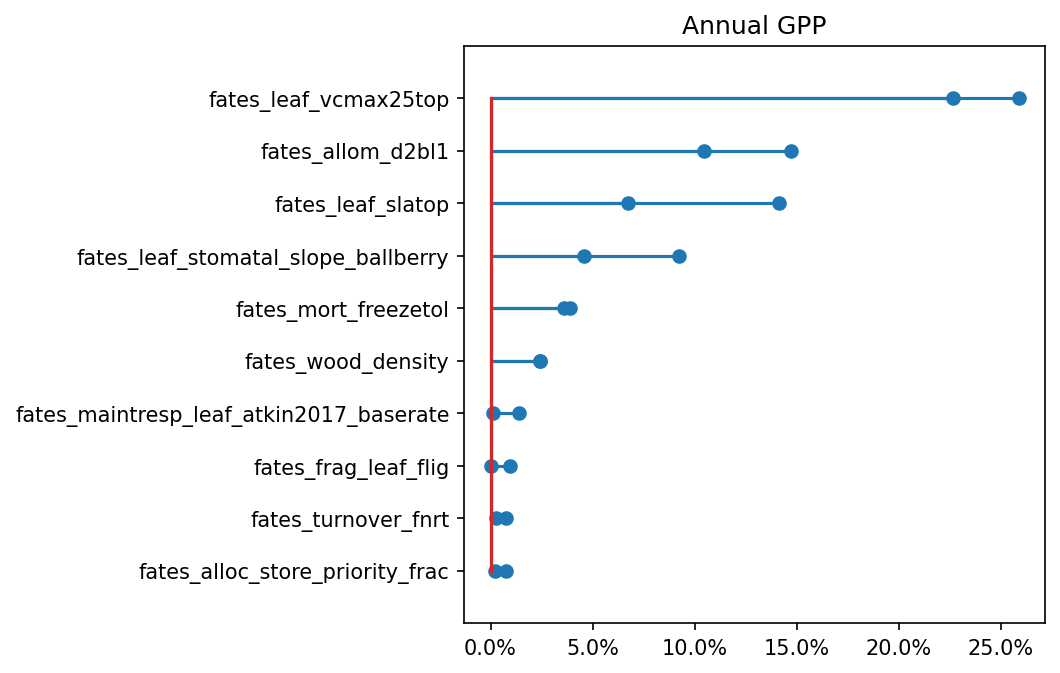

In [73]:
# Stem plot to show variance based sensitivity
# GPP
fig = plt.figure(figsize=(5,5), dpi=150)

order_maxvar = potential_variance_decomposition_data[0,:].argsort()[::-1]
order_maxvar_t10 = order_maxvar[0:10]
# Pick top 10
plt.stem(100*potential_variance_decomposition_data[0,order_maxvar_t10], orientation='horizontal')
plt.stem(100*minimum_variance_decomposition_data[0,order_maxvar_t10], orientation='horizontal')
plt.ylim([10, -1])

arr_param_broad = np.array(param_broad)
labels = arr_param_broad[order_maxvar_t10]
plt.yticks(np.arange(0,10), labels)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Annual GPP')
# ax.set_ylabel('Soil carbon, kgC m-2')
# ax.set_zlabel('Gross Primary Productivity, kgC m-2 yr-1')
# fig.tight_layout()
plt.show()


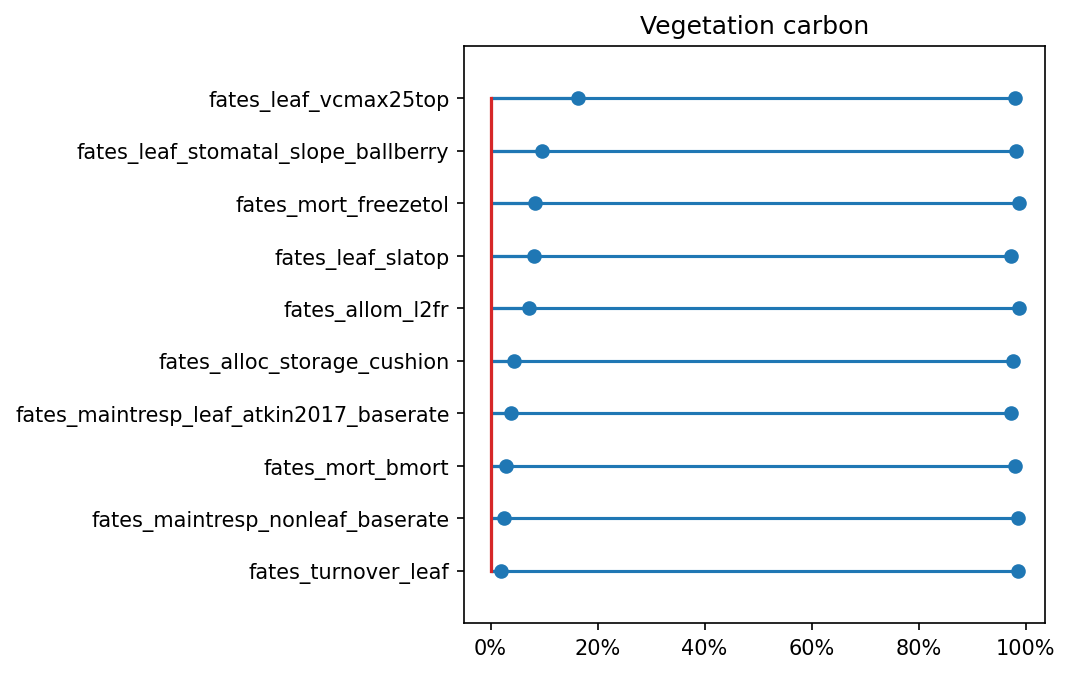

In [78]:
# vegetation carbon
fig = plt.figure(figsize=(5,5), dpi=150)

order_maxvar = minimum_variance_decomposition_data[1,:].argsort()[::-1]
order_maxvar_t10 = order_maxvar[0:10]
# Pick top 10
plt.stem(100*potential_variance_decomposition_data[1,order_maxvar_t10], orientation='horizontal')
plt.stem(100*minimum_variance_decomposition_data[1,order_maxvar_t10], orientation='horizontal')
plt.ylim([10, -1])

arr_param_broad = np.array(param_broad+param_nopft)
labels = arr_param_broad[order_maxvar_t10]
plt.yticks(np.arange(0,10), labels)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Vegetation carbon')
# ax.set_ylabel('Soil carbon, kgC m-2')
# ax.set_zlabel('Gross Primary Productivity, kgC m-2 yr-1')
# fig.tight_layout()
plt.show()


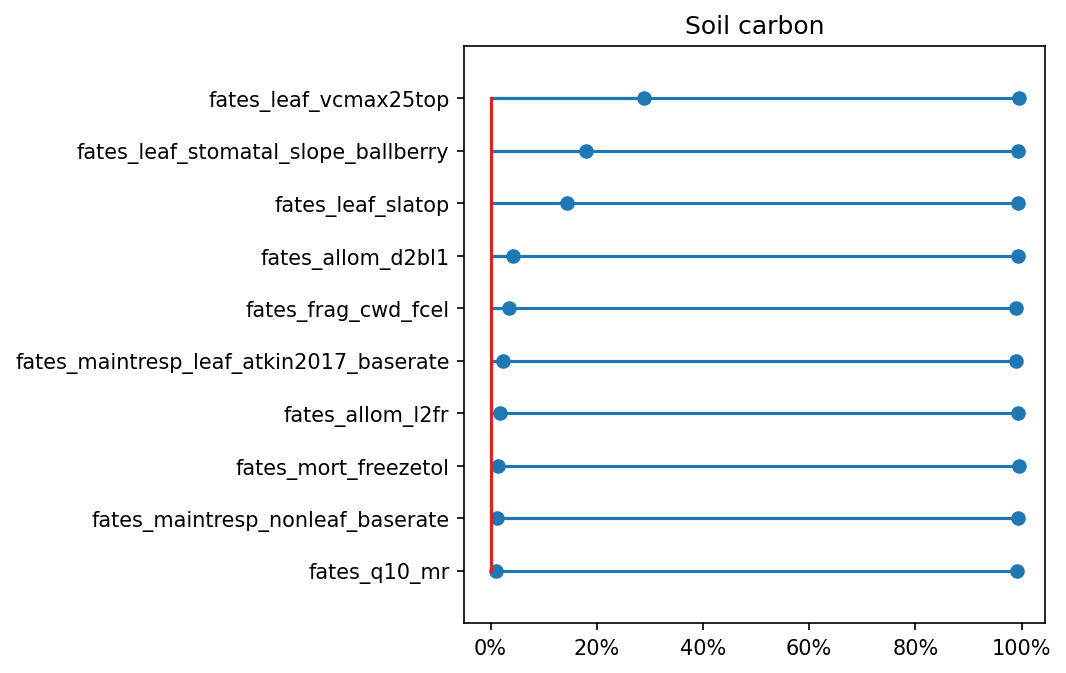

In [77]:
# soil carbon
fig = plt.figure(figsize=(5,5), dpi=150)

order_maxvar = minimum_variance_decomposition_data[2,:].argsort()[::-1]
order_maxvar_t10 = order_maxvar[0:10]
# Pick top 10
plt.stem(100*potential_variance_decomposition_data[2,order_maxvar_t10], orientation='horizontal')
plt.stem(100*minimum_variance_decomposition_data[2,order_maxvar_t10], orientation='horizontal')
plt.ylim([10, -1])

arr_param_broad = np.array(param_broad+param_nopft)
labels = arr_param_broad[order_maxvar_t10]
plt.yticks(np.arange(0,10), labels)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Soil carbon')
# ax.set_ylabel('Soil carbon, kgC m-2')
# ax.set_zlabel('Gross Primary Productivity, kgC m-2 yr-1')
# fig.tight_layout()
plt.show()

In [ ]:
minimum_variance_decomposition_data

In [ ]:
potential_variance_decomposition_data

### Visualization

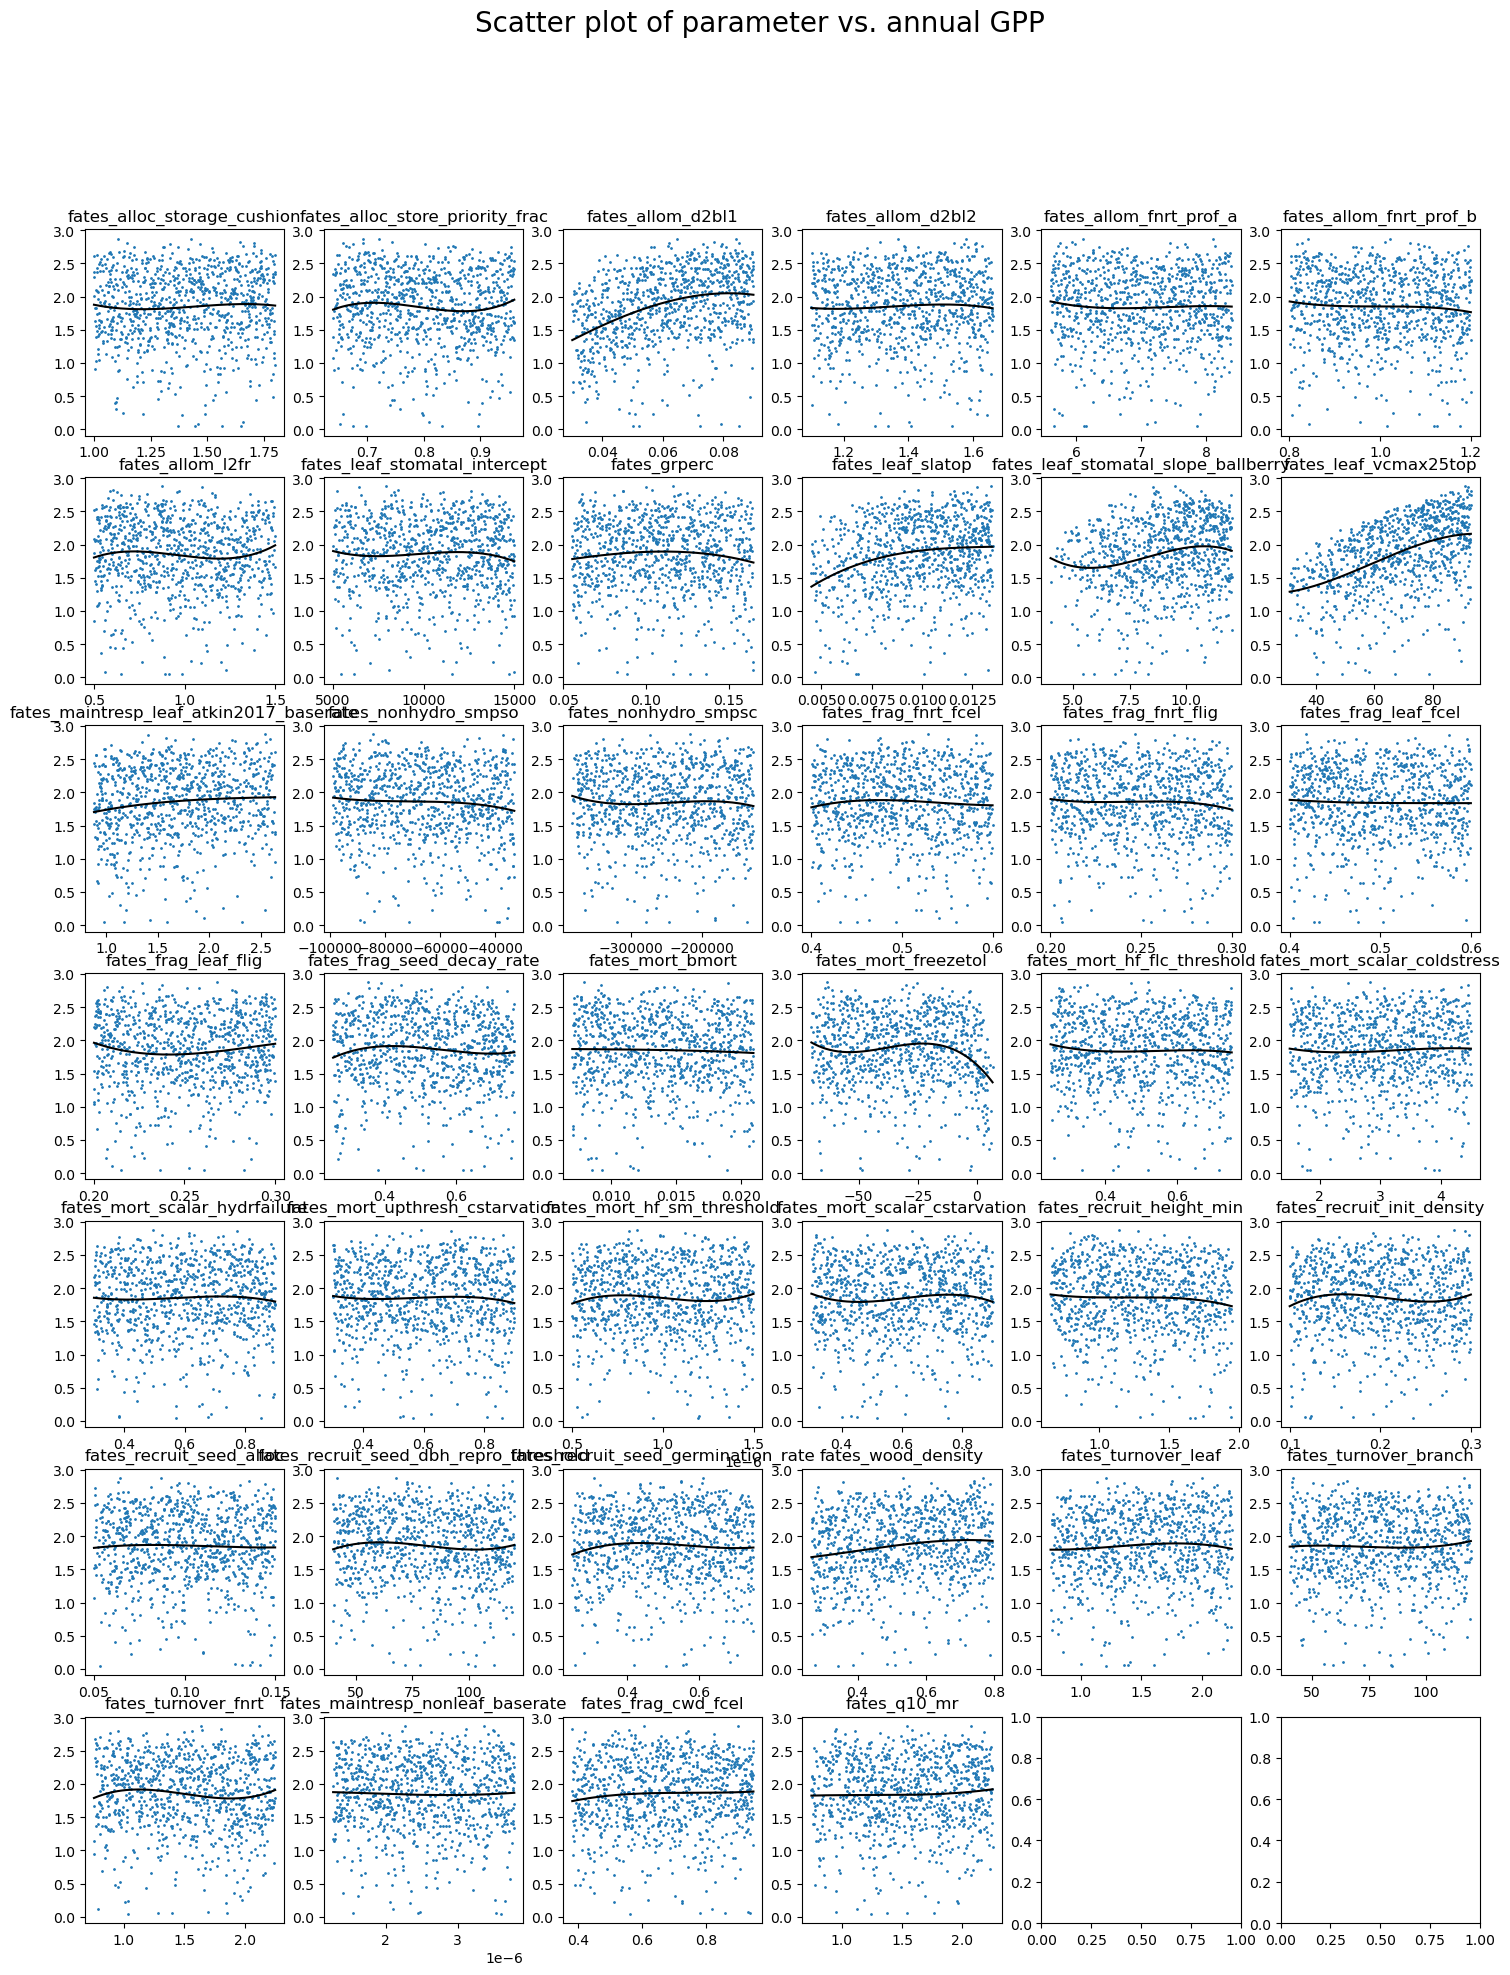

In [14]:
# Make a scatter plot with all parameters against GPP
fig, axs = plt.subplots(7, 6)
fig.set_figheight(22)
fig.set_figwidth(18)

for i in np.arange(0, 7):
    for j in np.arange(0, 6):
        param_idx = i*6+j
        if (param_idx < 40):
            y_unordered = sel_gpp[:]
            x_unordered = sel_param_value[:,param_idx]
            order = x_unordered.argsort()
            x = x_unordered[order]
            y = y_unordered[order]
            thespline = interpolate.UnivariateSpline(x, y, k=3)
            spline_prediction = thespline(x)
            
            axs[i, j].scatter(sel_param_value[:,param_idx], sel_gpp[:], s = 1)
            axs[i, j].plot(x, spline_prediction, 'k-')
            if (param_idx < 37):
                axs[i, j].set_title(param_broad[param_idx])
            else:
                axs[i, j].set_title(param_nopft[param_idx-37])
fig.suptitle('Scatter plot of parameter vs. annual GPP', fontsize=20)
# fig.tight_layout()
plt.show()

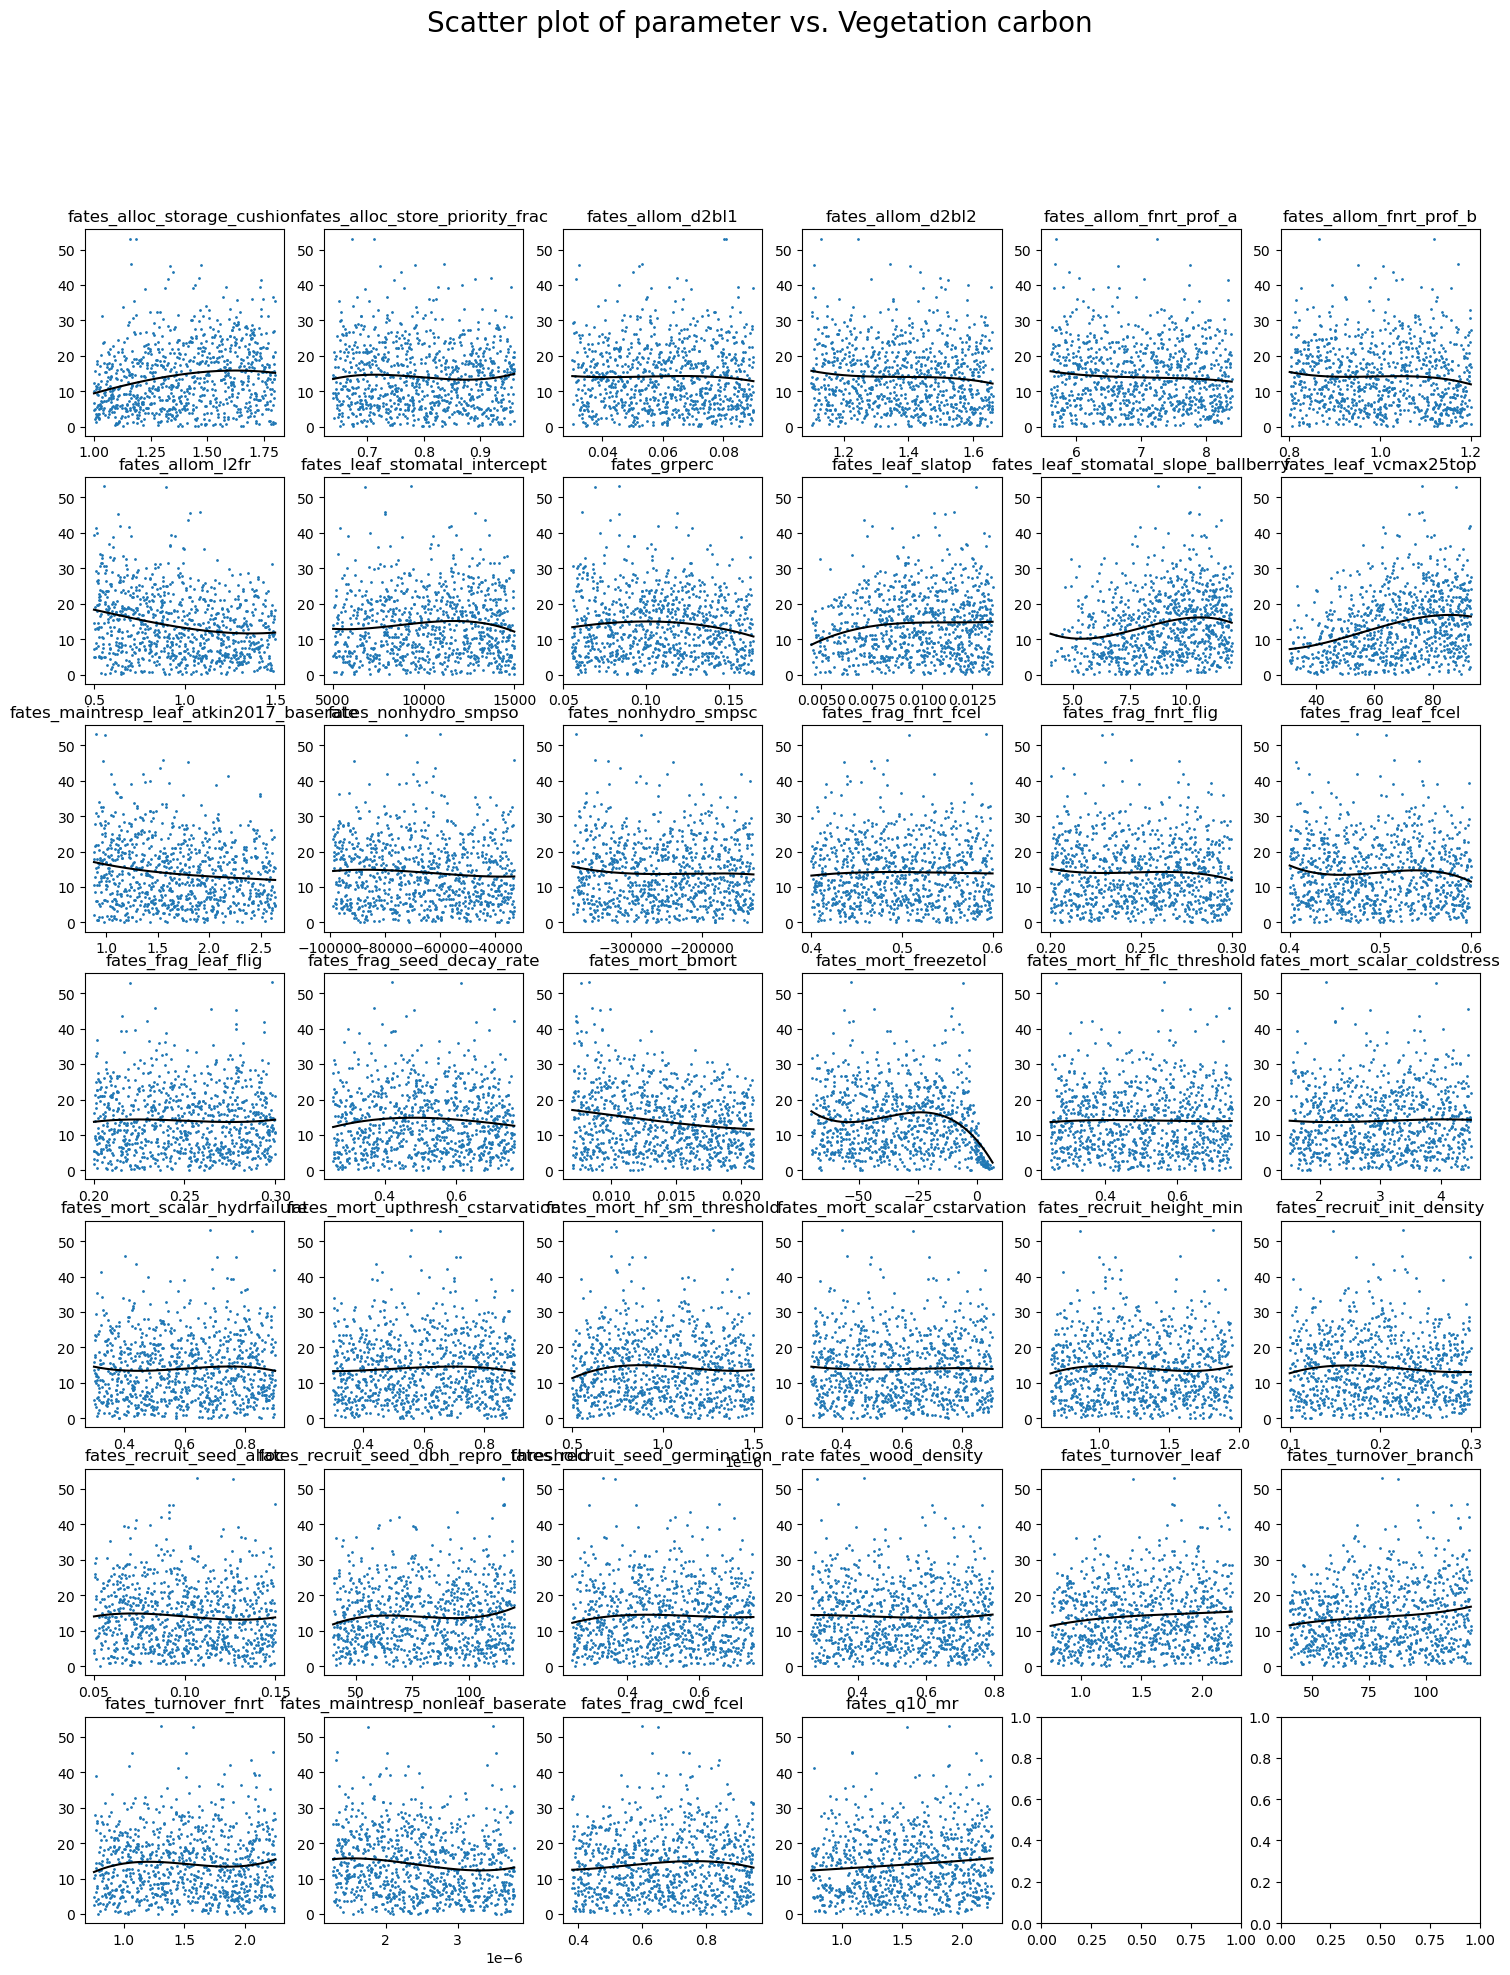

In [18]:
# Make a scatter plot with all parameters against vegetation carbon
fig, axs = plt.subplots(7, 6)
fig.set_figheight(22)
fig.set_figwidth(18)

for i in np.arange(0, 7):
    for j in np.arange(0, 6):
        param_idx = i*6+j
        if (param_idx < 40):
            y_unordered = sel_vegc[:]
            x_unordered = sel_param_value[:,param_idx]
            order = x_unordered.argsort()
            x = x_unordered[order]
            y = y_unordered[order]
            thespline = interpolate.UnivariateSpline(x, y, s=1e10, k=3)
            spline_prediction = thespline(x)
            
            axs[i, j].scatter(sel_param_value[:,param_idx], sel_vegc[:], s = 1)
            axs[i, j].plot(x, spline_prediction, 'k-')
            if (param_idx < 37):
                axs[i, j].set_title(param_broad[param_idx])
            else:
                axs[i, j].set_title(param_nopft[param_idx-37])
fig.suptitle('Scatter plot of parameter vs. Vegetation carbon', fontsize=20)
# fig.tight_layout()
plt.show()

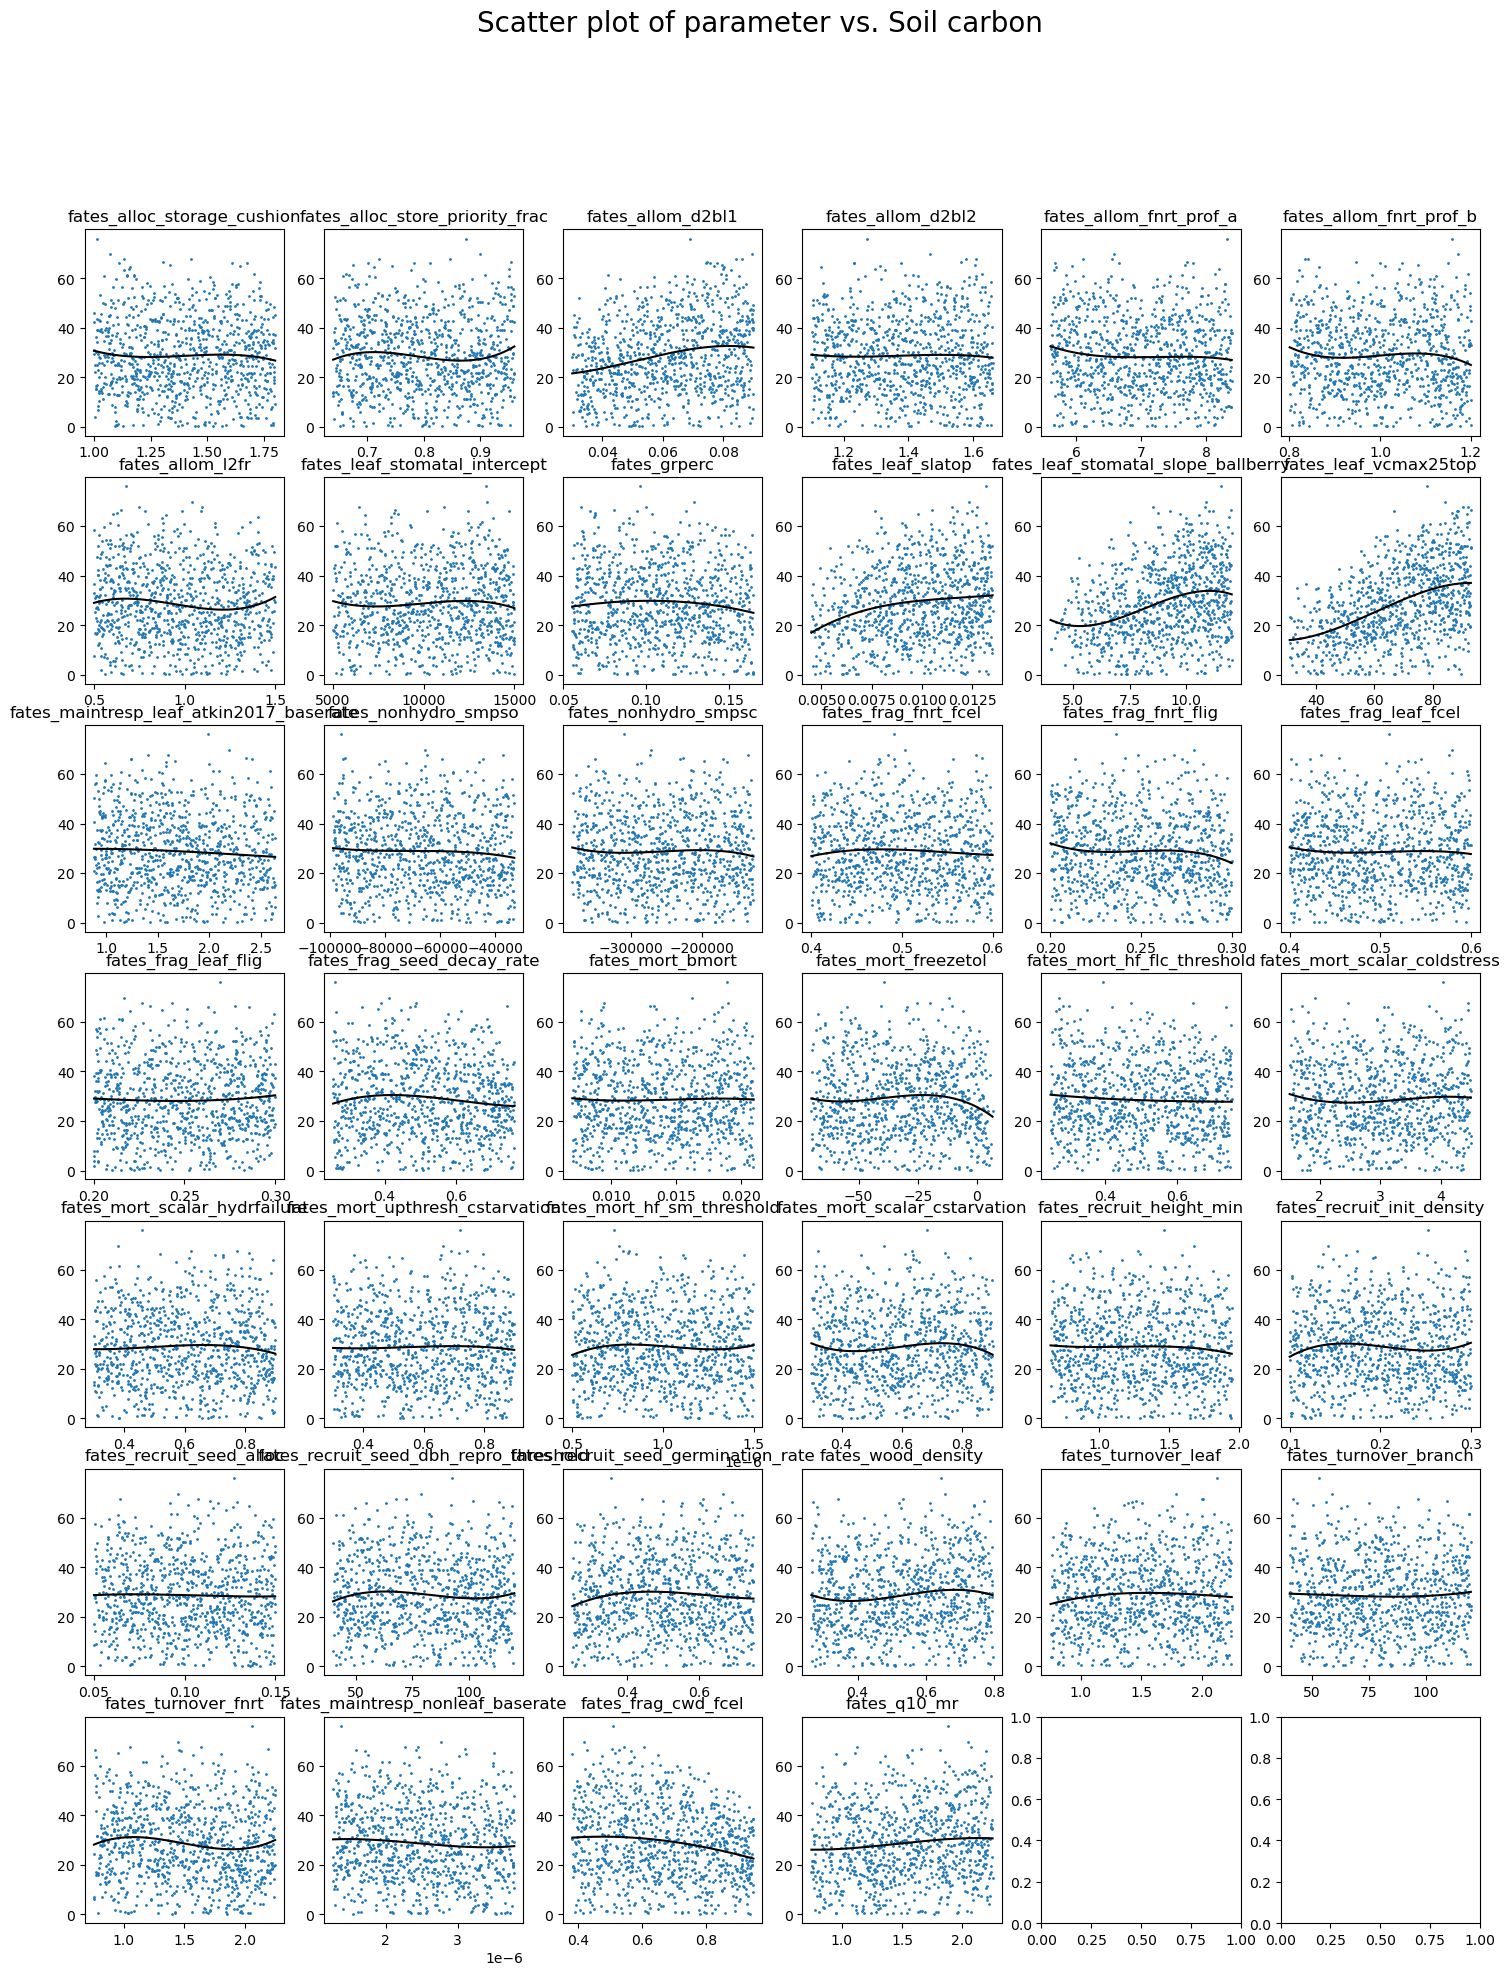

In [19]:
# Make a scatter plot with all parameters against soil carbon
fig, axs = plt.subplots(7, 6)
fig.set_figheight(22)
fig.set_figwidth(18)

for i in np.arange(0, 7):
    for j in np.arange(0, 6):
        param_idx = i*6+j
        if (param_idx < 40):
            y_unordered = sel_soilc[:]
            x_unordered = sel_param_value[:,param_idx]
            order = x_unordered.argsort()
            x = x_unordered[order]
            y = y_unordered[order]
            thespline = interpolate.UnivariateSpline(x, y, s=1e10, k=3)
            spline_prediction = thespline(x)
            
            axs[i, j].scatter(sel_param_value[:,param_idx], sel_soilc[:], s = 1)
            axs[i, j].plot(x, spline_prediction, 'k-')
            if (param_idx < 37):
                axs[i, j].set_title(param_broad[param_idx])
            else:
                axs[i, j].set_title(param_nopft[param_idx-37])
fig.suptitle('Scatter plot of parameter vs. Soil carbon', fontsize=20)
# fig.tight_layout()
plt.show()

### Examine candidates

In [23]:
# Parameter list of all candidates
arr_param_value = np.array(param_value)
df_params = pd.DataFrame(arr_param_value, columns=param_broad+param_nopft)
df_params

fates_alloc_storage_cushion  fates_alloc_store_priority_frac  \
0                      1.013981                         0.684355   
1                      1.692445                         0.903381   
2                      1.077336                         0.771750   
3                      1.382083                         0.835498   
4                      1.365670                         0.824442   
5                      1.190822                         0.859470   
6                      1.441157                         0.675572   
7                      1.111660                         0.722611   
8                      1.302080                         0.832273   
9                      1.333105                         0.740612   
10                     1.424599                         0.750637   
11                     1.383343                         0.753152   
12                     1.338676                         0.786720   
13                     1.075801                         0.886935   
14                     1.576720                         0.751833   
15                     1.244827                         0.646094   
16                     1.756890                         0.805695   
17                     1.479045                         0.731391   
18                     1.271669                         0.644929   
19                     1.102928                         0.646661   
20                     1.593740                         0.868584   
21                     1.288438                         0.885892   
22                     1.105216                         0.821333   
23                     1.153225                         0.747203   
24                     1.629627                         0.825907   
25                     1.485925                         0.753918   
26                     1.610652                         0.818545   
27                     1.410622                         0.757486   
28                     1.537644                         0.756792   
29                     1.189867                         0.829734   
30                     1.083440                         0.703893   
31                     1.519873                         0.828598   
32                     1.330769                         0.719717   
33                     1.709867                         0.679570   
34                     1.763759                         0.791644   
35                     1.037644                         0.762836   
36                     1.480286                         0.760734   

    fates_allom_d2bl1  fates_allom_d2bl2  fates_allom_fnrt_prof_a  \
0            0.042757           1.405477                 7.968896   
1            0.062484           1.596667                 7.687656   
2            0.078697           1.504468                 5.889217   
3            0.053178           1.452746                 8.382326   
4            0.056410           1.283662                 7.749569   
5            0.063151           1.377852                 5.615837   
6            0.083811           1.536947                 8.171324   
7            0.036251           1.462993                 7.231229   
8            0.081889           1.277550                 7.887112   
9            0.063683           1.354526                 7.125794   
10           0.054321           1.649976                 8.251658   
11           0.080619           1.453913                 8.392792   
12           0.060810           1.122477                 6.647679   
13           0.076108           1.197089                 6.220843   
14           0.057151           1.508151                 5.923228   
15           0.060584           1.141221                 8.214488   
16           0.069314           1.174495                 8.120988   
17           0.077375           1.505474                 6.540393   
18           0.054023           1.588514                 7.529222   
19           0.089006           1.64466

#### Check the vegetation size-class structure and age structure and have a second round of picking candidates

In [21]:
oak_pine_df = pd.read_csv('Size_distributions_Puebla.csv')

In [1]:
# Open the file and obtain the last value
# This step will take much longer than expected.
start = time.time()

num_sz_collect = []
gpp_collect = []
npp_collect = []
lai_collect = []
leafc_collect = []
reprodc_collect = []
sapwoodc_collect = []
storec_collect = []
frc_collect = []
rec_collect = []
mort_collect = []

block_ens = [255, 145, 400, 400, 400]
# Path to all ensemble members
block_path = ['ppe_pool/fates_test1/', \
              'ppe_pool/fates_test256/', \
              'ppe_pool/fates_test401/', \
              'ppe_pool/fates_test801/', \
              'ppe_pool/fates_test1201/']
block_prefix = ['fates_test_2024-02-12_e9515ed7a8_5d40c9e6.elm_',\
               'fates_test256_2024-02-12_e9515ed7a8_5d40c9e6.elm_', \
               'fates_test401_2024-02-12_e9515ed7a8_5d40c9e6.elm_', \
               'fates_test801_2024-02-12_e9515ed7a8_5d40c9e6.elm_', \
               'fates_test1201_2024-02-13_e9515ed7a8_5d40c9e6.elm_']

# Loop through blocks
for i in candidates:
    block_ind = np.float(i)/400.0
    if(block_ind < 0.6375):
        k = 0
        ens = i
    else:
        if(block_ind < 1.0):
            k = 1
            ens = i-255
        else:
            if(block_ind < 2.0):
                k = 2
                ens = i - 400
            else:
                if(block_ind < 3.0):
                    k = 3
                    ens = i - 800
                else:
                    k = 4
                    ens = i - 1200
    ens_num = str(ens+1).zfill(4)
    # Some issue causes the last 400 ensemble member not finishing the job
    # Use the latest available output
#     print('Current block number: ', k)
#     print('Current ens_num number: ', ens)
    fpath = block_path[k] + block_prefix[k]+ens_num+'.h0.1965-02-01-00000.nc'
    dtc = nc4.Dataset(fpath)
    dnum_sz = dtc['FATES_NPLANT_SZ'][:]
    dgpp = dtc['FATES_GPP'][:]
    dnpp = dtc['FATES_NPP'][:]
    dlai = dtc['FATES_LAI'][:]
    dleafc = dtc['FATES_LEAFC'][:]
    dreprodc = dtc['FATES_REPROC'][:]
    dsapwoodc = dtc['FATES_SAPWOODC'][:]
    dstorec = dtc['FATES_STOREC'][:]
    dfrc = dtc['FATES_FROOTC'][:]
    drec = dtc['FATES_RECRUITMENT_PF'][:]
    dmort = dtc['FATES_MORTALITY_CANOPY_SZ'][:]
    
    dtc.close()

    # Obtain the mean results
    num_sz_collect.append(np.nanmean(dnum_sz[:,:,0], axis = 0))
    gpp_collect.append(np.nanmean(dgpp[:,0])*3600*24*365)
    npp_collect.append(np.nanmean(dnpp[:,0])*3600*24*365)
    lai_collect.append(np.nanmean(dlai[:,0]))
    leafc_collect.append(np.nanmean(dleafc[:,0]))
    reprodc_collect.append(np.nanmean(dreprodc[:,0]))
    sapwoodc_collect.append(np.nanmean(dsapwoodc[:,0]))
    storec_collect.append(np.nanmean(dstorec[:,0]))
    frc_collect.append(np.nanmean(dfrc[:,0]))
    rec_collect.append(np.nanmean(drec[:,0,0]))
    mort_collect.append(np.nanmean(np.nansum(dmort[:,:,0], axis=1)))

# transfer into np array 
arr_num_sz = np.array(num_sz_collect)
arr_gpp = np.array(gpp_collect)
arr_npp = np.array(npp_collect)
arr_lai = np.array(lai_collect)
arr_leafc = np.array(leafc_collect)
arr_reprodc = np.array(reprodc_collect)
arr_sapwoodc = np.array(sapwoodc_collect)
arr_storec = np.array(storec_collect)
arr_frc = np.array(frc_collect)
arr_rec = np.array(rec_collect)
arr_mort = np.array(mort_collect)

end = time.time()
print('Time elapsed: ', end - start)

NameError: name 'time' is not defined

#### A series of examination. 
#### 1) NPP/GPP ratio 

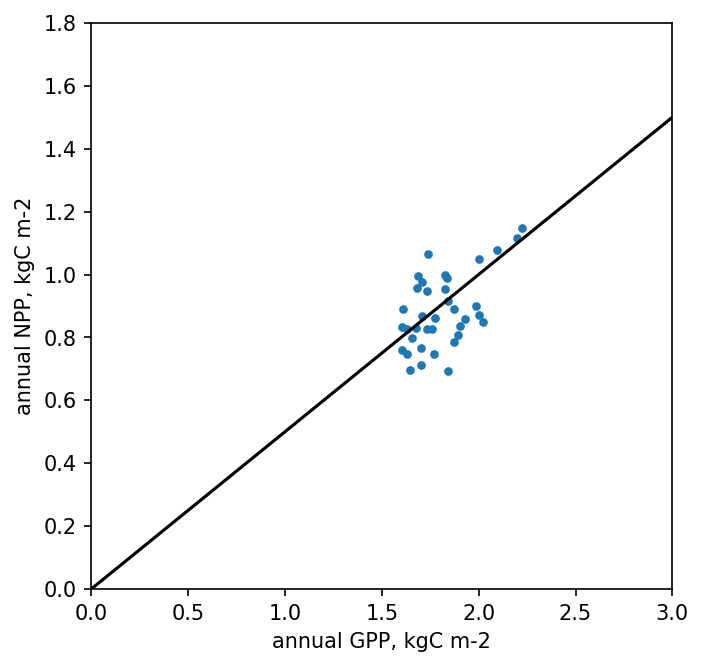

In [82]:
fig = plt.figure(figsize=(5,5), dpi=150)
plt.scatter(arr_gpp, arr_npp, s=10)
x_line = np.arange(-1.0,4.0,0.1)
y_line = np.arange(-0.5,2.0,0.05)
plt.xlabel('annual GPP, kgC m-2')
plt.ylabel('annual NPP, kgC m-2')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 1.8])
plt.plot(x_line, y_line, 'k-')

#### 2) NPP to LAI

(0.0, 1.8)

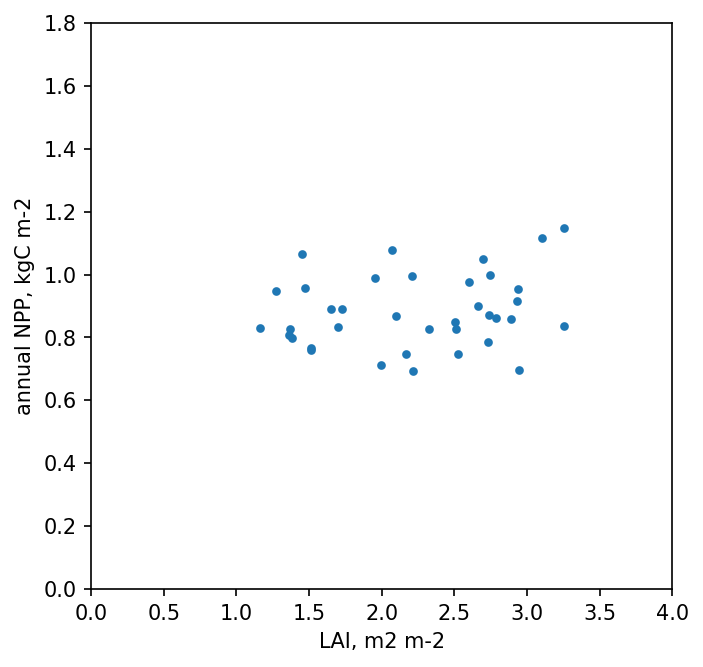

In [83]:
fig = plt.figure(figsize=(5,5), dpi=150)
plt.scatter(arr_lai, arr_npp, s=10)
x_line = np.arange(-1.0,4.0,0.1)
y_line = np.arange(-0.5,2.0,0.05)
plt.xlabel('LAI, m2 m-2')
plt.ylabel('annual NPP, kgC m-2')
plt.xlim([0.0, 4.0])
plt.ylim([0.0, 1.8])
# plt.plot(x_line, y_line, 'k-')

#### 3) LAI to leaf C

(0.0, 0.3)

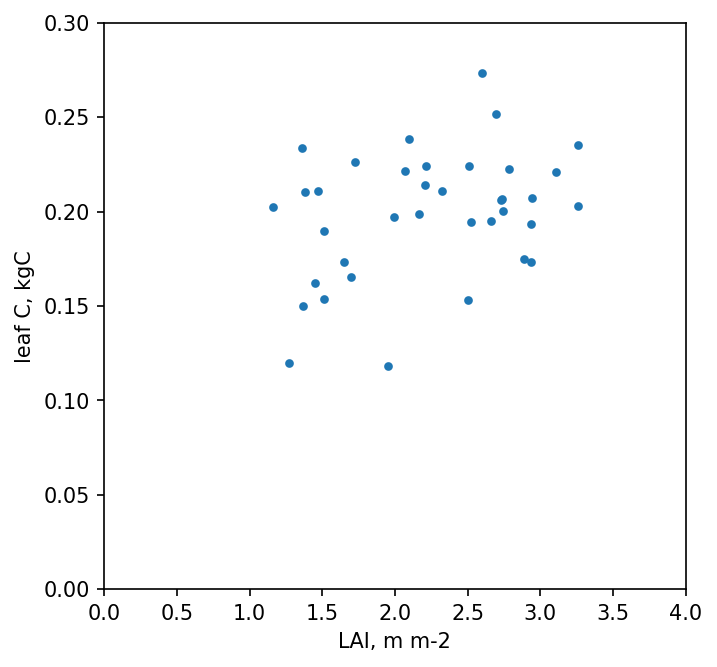

In [84]:
fig = plt.figure(figsize=(5,5), dpi=150)
plt.scatter(arr_lai, arr_leafc, s=10)
x_line = np.arange(-1.0,4.0,0.1)
y_line = np.arange(-0.5,2.0,0.05)
plt.xlabel('LAI, m m-2')
plt.ylabel('leaf C, kgC')
plt.xlim([0.0, 4.0])
plt.ylim([0.0, 0.3])
# plt.plot(x_line, y_line, 'k-')

#### 4) Root to shoot ratio

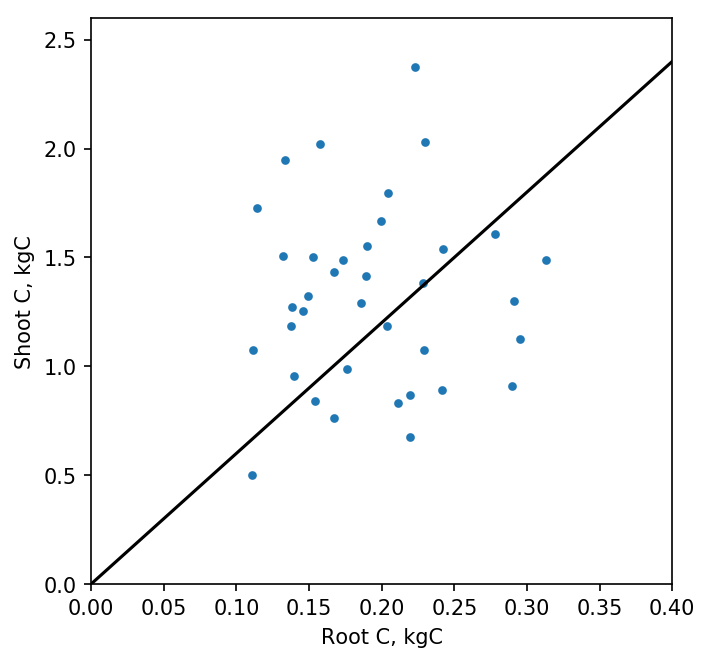

In [91]:
fig = plt.figure(figsize=(5,5), dpi=150)
plt.scatter(arr_frc, arr_leafc+arr_storec+arr_sapwoodc+arr_reprodc, s=10)
x_line = np.arange(-0.2,0.6,0.1)
y_line = np.arange(-1.2,3.0,0.6)
plt.xlabel('Root C, kgC')
plt.ylabel('Shoot C, kgC')
plt.xlim([0.0, 0.4])
plt.ylim([0.0, 2.6])
plt.plot(x_line, y_line, 'k-')

#### 5) Recruitment to mortality ratio

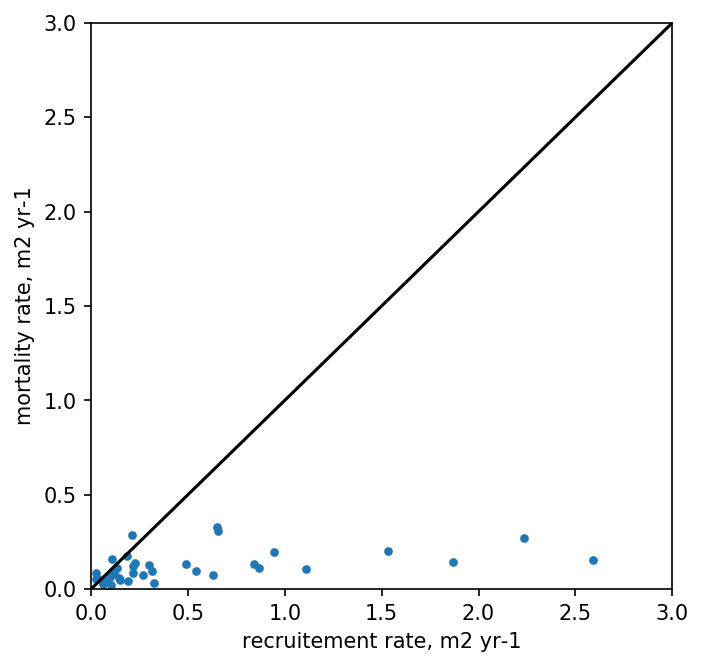

In [97]:
fig = plt.figure(figsize=(5,5), dpi=150)
plt.scatter(arr_rec, arr_mort*30, s=10)
x_line = np.arange(-1.0,5.0,0.1)
y_line = np.arange(-1.0,5.0,0.1)
plt.xlabel('recruitement rate, #plants m2 yr-1')
plt.ylabel('mortality rate, #plants m2 yr-1')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.plot(x_line, y_line, 'k-')

#### 6) size distribution against observed Peuble state statistics 

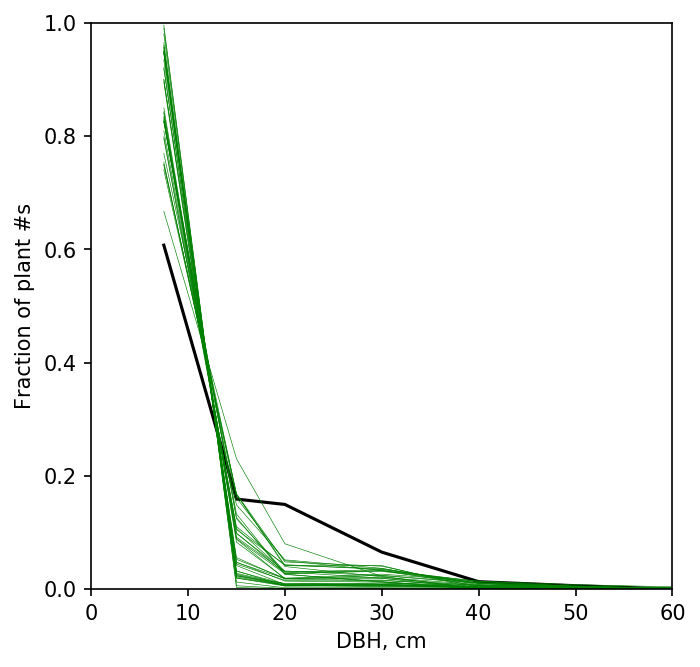

In [116]:
fig = plt.figure(figsize=(5,5), dpi=150)
lower_bin_edge_obs = np.array(df_sz['lower_bin_edge'])
lower_bin_edge_ens = np.array([7.5, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200])
obs_sz_num = np.array(df_sz['Oak'])
obs_sz_frac = obs_sz_num/np.sum(obs_sz_num)
plt.plot(lower_bin_edge_obs, obs_sz_frac, 'k-')
plt.xlim([0.0, 60.0])
plt.ylim([0.0, 1.0])
plt.xlabel('DBH, cm')
plt.ylabel('Fraction of plant #s')
for i in np.arange(0, len(candidates)):
    ens_sz_frac = arr_num_sz[i]/np.sum(arr_num_sz[i])
    plt.plot(lower_bin_edge_ens, ens_sz_frac, 'g-', linewidth=0.3)

#### 7. Litter input vs. SOC